In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import lightkurve as lk
from matplotlib.collections import LineCollection
from tqdm import tqdm_notebook

import glob, os

from astropy.table import Table
plt.rcParams['font.size'] = 20

In [2]:
from scripts import *

In [3]:
tics, time, flux, errs, sects, data_all = load_lightcurve('CR Dra')

/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/lightkurve-2.0.1.dev0-py3.7.egg/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)


In [4]:
period = get_rotation_period(tics,time,flux,errs)
print(period)

Finding most likely periods: 100%|██████████| 4/4 [00:00<00:00, 15.46it/s]

1.9866960997602174


In [5]:
avg_preds = run_cnn(tics,time,flux,errs)

Can only use stella.ConvNN.predict().


100%|██████████| 4/4 [00:16<00:00,  4.07s/it]


In [6]:
flare_table = get_flares(tics,time,flux,avg_preds,errs)

Finding & Fitting Flares: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


In [7]:
def get_flare_rate(time,flare_table):
    totaltime = 0
    for i in range(len(time)):
        totaltime += (len(time[i])*2)
    totaltime = (totaltime*u.minute).to(u.day)
    return np.nansum(flare_table['prob'])/totaltime


In [8]:
flare_rate = get_flare_rate(time,flare_table)
print(flare_rate)

1.1745504697110407 1 / d


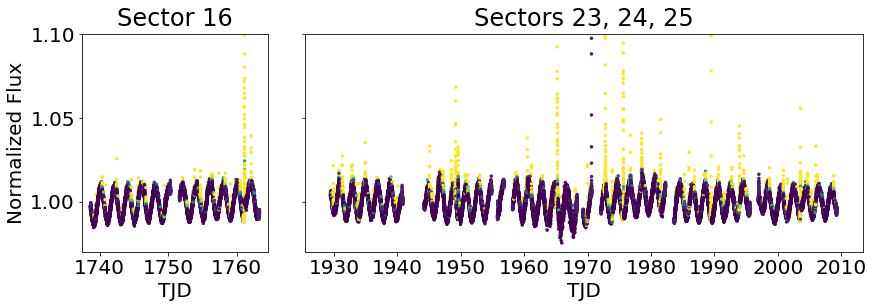

In [11]:
do_plots(tics,time,flux,avg_preds,errs,data_all)
plt.savefig('test_cr_dra.png')